### 검색

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 64.7 MB/s eta 0:00:00


In [ ]:
import faiss
import json
import  torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd

import os
import io
import requests
from PIL import Image
import PIL
from google.colab import files
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

In [ ]:
# 임베딩 CLIP 모델 정보
model_name = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)


# text 임베딩 벡터 반환
def encode_text(text):
    inputs = processor(text=[text], return_tensors="pt")

    with torch.no_grad():
        text_features = clip_model.get_text_features(**inputs)

    text_features = torch.nn.functional.normalize(text_features, p=2, dim=-1) #정규화

    return text_features.cpu().numpy().astype("float32")

# 검색
def search_similar_images(text, image_index, top_k=5):
    text_vec = encode_text(text)
    distances, indices = image_index.search(text_vec, top_k)

    # 개별 벡터 가져오기
    image_embed_vectors = []
    for i in indices[0]:  # 이차원 배열이므로 첫 번째 row에서 가져오기
      vec = np.zeros((image_index.d,), dtype=np.float32)  # 빈 벡터 생성
      image_index.reconstruct(int(i), vec)  # 특정 ID의 벡터 복원
      image_embed_vectors.append(vec) # 저장

    image_embed = torch.tensor(np.array(image_embed_vectors), dtype=torch.float32)


    return image_embed, distances

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
# 이미지 입력 받기

upload_dir = "/content/uploads"
os.makedirs(upload_dir, exist_ok=True)

# 업로드된 이미지 경로 저장
uploaded_image_paths = []

# Colab에서 이미지 파일 업로드 및 저장
def upload_images():
    uploaded_files = files.upload()
    for file_name in uploaded_files.keys():
        file_path = os.path.join("/content", file_name)  # 기본 업로드 경로
        move_path = os.path.join(upload_dir, file_name)  # 사용자 지정 디렉토리

        # 파일을 원하는 디렉토리로 이동
        os.rename(file_path, move_path)

        uploaded_image_paths.append(move_path)
        print(f"save image : {move_path}")


# 버튼 설정
upload_button = widgets.Button(description="이미지 업로드")

# 클릭 시 실행
def on_upload_clicked(b):
    upload_images()


upload_button.on_click(on_upload_clicked)

# 출력
display(upload_button)

Button(description='이미지 업로드', style=ButtonStyle())

Saving 스크린샷 2025-02-19 035715.jpg to 스크린샷 2025-02-19 035715.jpg
save image : /content/uploads/스크린샷 2025-02-19 035715.jpg


Saving 스크린샷 2025-02-19 035819.jpg to 스크린샷 2025-02-19 035819.jpg
save image : /content/uploads/스크린샷 2025-02-19 035819.jpg


In [ ]:
# DB 설정
#faiss_index_filename = "/content/faiss_index_vitL14.index"  # FAISS 벡터 DB 파일 경로 # 풍경 이미지
faiss_index_filename = "/content/dog_ad.index"  # FAISS 벡터 DB 파일 경로 # 강아지, 고양이 이미지


# FAISS 인덱스 로드
db_index = faiss.read_index(faiss_index_filename)

In [ ]:
# 텍스트 입력
query_text = "small dog wearing a vibrant pink velvet collar with elegant gold hardware, sitting happily in a cozy indoor setting gazing at its owner."
# input 이미지 임베딩 + 정규화

input_images = [Image.open(path).convert("RGB") for path in uploaded_image_paths] # 입력 이미지 리스트


top_k = 3 # 최근접 이웃 개수 5-6개?

In [ ]:
# 유사한 이미지 벡터 검색
similar_images_emb, distances = search_similar_images(query_text, db_index, top_k=top_k)


# top_k 이미지에 대한 가중치 계산

# 해당 부분 설정은 자유 -> 다양하게 바꿀 수 있음
weights = np.array(distances[0]) # 거리 저장
#weights = 0.4,0.1,0.1, #역순
#print(weights)
# 정규화 (합이 1이 되도록)
normalized_weights = weights / np.sum(weights)
top_k_w = normalized_weights.tolist() # 가중치를 list 타입으로 받음
print(top_k_w)

[0.33247771859169006, 0.33247771859169006, 0.33504459261894226]


### 생성

In [ ]:
### 라이브러리 파일 교체

import os
from google.colab import files

# 교체할 파일 경로
file_path = "/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/kandinsky/pipeline_kandinsky_prior.py"

# 파일 업로드
uploaded_files = files.upload()

# 업로드된 파일 처리
for file_name in uploaded_files.keys():
    # 업로드된 파일이 Python 파일인지 확인
    if file_name.endswith(".py"):
        upload_file_path = os.path.join("/content", file_name)  # Colab 기본 업로드 경로

        # 파일을 diffusers 경로로 이동하여 덮어쓰기
        os.rename(upload_file_path, file_path)

        print(f"업로드 완료")
    else:
        print(f"ERROR")

Saving pipeline_kandinsky_prior_s.py to pipeline_kandinsky_prior_s.py
업로드 완료


In [ ]:
from diffusers import KandinskyPriorPipeline, KandinskyPipeline

# 모델 불러오기
pipe_prior = KandinskyPriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-1-prior", torch_dtype=torch.float16
)
pipe_prior.to("cuda")


pipe = KandinskyPipeline.from_pretrained("kandinsky-community/kandinsky-2-1", torch_dtype=torch.float16)
pipe.to("cuda")

model_index.json:   0%|          | 0.00/500 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

prior%2Fconfig.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

image_encoder%2Fconfig.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

(…)age_processor%2Fpreprocessor_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.09G [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/626 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/495M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/767 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

movq%2Fconfig.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/318 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/271M [00:00<?, ?B/s]

tokenizer%2Ftokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You are using a model of type xlm-roberta to instantiate a model of type M-CLIP. This is not supported for all configurations of models and can yield errors.


KandinskyPipeline {
  "_class_name": "KandinskyPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "kandinsky-community/kandinsky-2-1",
  "movq": [
    "diffusers",
    "VQModel"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "kandinsky",
    "MultilingualCLIP"
  ],
  "tokenizer": [
    "transformers",
    "XLMRobertaTokenizerFast"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ]
}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
torch.Size([1, 768])
add top k image
9
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

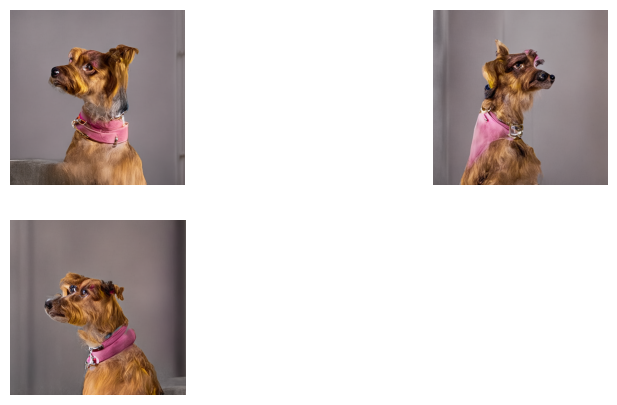

In [ ]:
# 텍스트 가중치
query_text_w = 0.2
cond_image_w = 0.6
# 생성 이미지 개수
num_images_per_prompt = 3

# image_text 컨디션 리스트 - 텍스트를 이미지에 구현해야 하는 특징에 따라 세분화
images_texts = [query_text,"vibrant pink velvet collar", "dog", "sits gazing owner"] + input_images

# 가중치 설정 - 텍스트 가중치 0.2씩, 이미지 합 0.5로 주어 이미지쪽에 가중치 더 주는 실험
weights = [query_text_w, 0.2, 0.2,0.2] +[0.3,0.2]


prompt = query_text
prior_out = pipe_prior.interpolate(images_texts,
                                   weights,
                                   search_k=True,
                                   top_k_image = similar_images_emb.to("cuda", dtype=torch.float16),
                                   top_k_w =top_k_w)

"""
변수 설명
image_text : 이미지+텍스트 컨디션 리스트
weight : 이미지+텍스트 컨디션 가중치
search_k : 최근접 이미지 k를 삽입할 것인지 여부 (bool)
top_k_image : 찾은 최근접 이미지 벡터
top_k_w : 최근접 이미지 가중치
"""


new_image_add = pipe(prompt, **prior_out, height=768, width=768, num_images_per_prompt=num_images_per_prompt).images
#prior_out은 image_embs + negative image embs로 구성됨
# 여기서도  매개변수 지정 가능
"""
num_images_per_prompt : 생성할 이미지 개수
guidance_scale : prompt 집중 정도
"""
if num_images_per_prompt > 1:
  plt.figure(figsize=(10,5))
  for i in range(len(new_image_add)):
    plt.subplot(2, round(len(new_image_add)/2), i+1)
    plt.imshow(new_image_add[i])
    plt.axis('off')
  plt.show()
else:
  plt.imshow(new_image_add)
  plt.axis('off')
  plt.show()

## 성능 평가
- 수정 X

In [ ]:
# CLIP Score - text

model_name = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)


# 텍스트와 생성 이미지 사이 유사도 평균을 반환
def c_clip_score_text(images, prompt):
    # 생성 이미지를 변환
    image_list = [image.convert("RGB") for image in images ]

    # CLIP Processor를 사용하여 입력 변환
    text_inputs = processor(text=[prompt], return_tensors="pt", padding=True)
    image_inputs = processor(images=image_list, return_tensors="pt", padding=True)


    with torch.no_grad():
        text_emb = clip_model.get_text_features(**text_inputs)
        image_emb = clip_model.get_image_features(**image_inputs)  # 이미지-텍스트 유사도 점수


    # 정규화
    text_emb =  torch.nn.functional.normalize(text_emb, p=2, dim=-1) # L2 정규화
    image_emb =  torch.nn.functional.normalize(image_emb, p=2, dim=-1) # L2 정규화

    # 유사도 계산을 위한 차원 확장
    text_emb = text_emb.expand(image_emb.shape[0], -1)  # (n, 768)

    # 코사인 유사도 계산
    similarity = torch.nn.functional.cosine_similarity(text_emb, image_emb, dim=-1)

    return similarity.mean()  # 평균

# CLIP Score 비교
clip_score_text = c_clip_score_text(new_image_onlytext, query_text)
clip_score_added_cond = c_clip_score_text(new_image_add, query_text)

print(f"CLIP Score only text: {clip_score_text:.4f}")
print(f"CLIP Score with image: {clip_score_added_cond:.4f}")

CLIP Score only text: 0.3481
CLIP Score with image: 0.2589


In [ ]:
# CLIP Score - image

# 입력 이미지 임베딩 벡터와 생성 이미지 사이의 유사도를 반환
def c_clip_score_image(images, input_emb):

    # 생성 이미지를 변환
    image_list = [image.convert("RGB") for image in images ]

    # CLIP Processor를 사용하여 생성된 이미지를 변환
    image_inputs_g = processor(images=image_list, return_tensors="pt", padding=True)


    with torch.no_grad():
        image_emb = clip_model.get_image_features(**image_inputs_g) # 임베딩 벡터 생성


    image_emb =  torch.nn.functional.normalize(image_emb, p=2, dim=-1) # L2 정규화

    # 유사도 계산을 위한 차원 확장
    input_emb = input_emb.expand(image_emb.shape[0], -1)  # (n, 768)

    # 코사인 유사도 계산
    similarity = torch.nn.functional.cosine_similarity(input_emb, image_emb, dim=-1)

    return similarity.mean()  # 평균 반환

# 입력 이미지 벡터로 변환
image_inputs = processor(images=input_images, return_tensors="pt", padding=True)
with torch.no_grad():
  image_embeddings = clip_model.get_image_features(**image_inputs)
image_embeddings =  torch.nn.functional.normalize(image_embeddings, p=2, dim=-1) # L2 정규화

# CLIP Score 비교
for i, emb in enumerate(image_embeddings):
  print(f'입력 이미지 경로 :  {uploaded_image_paths[i]}')
  score = c_clip_score_image(new_image_add, emb)
  print(f'CLIP Score with image : {score:.4f}')

  score = c_clip_score_image(new_image_onlytext, emb)
  print(f'CLIP Score only text: {score:.4f}')

입력 이미지 경로 :  /content/uploads/a21f205dabc5a51860feb31cb53b1a1f.jpg
CLIP Score with image : 0.7184
CLIP Score only text: 0.5801


In [ ]:
uploaded_image_paths

['/content/uploads/a21f205dabc5a51860feb31cb53b1a1f.jpg']

In [ ]:
pip install -U langchain langchain-community openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.3/472.3 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.61.1
    Uninstalling openai-1.61.1:
      Successfully uninstalled openai-1.61.1
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.18
    Uninstalling langchain-0.3.18:
      Successfully uninstalled langchain-0.3.18


In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatOpenAI
from langchain.schema import StrOutputParser

In [ ]:
# 쿼리문
query_text = input('query :')

# LLM 템플릿 구성
template = """
    You are an expert in visual content decomposition and summarization for image generation. Your task is to analyze the given query text, extract key visual elements, and generate a concise yet comprehensive summary that preserves the essence of the original input while making it more efficient for image generation.

    ### **Instructions:**
    1. Carefully read the **query text** and extract the key visual elements that must appear in the generated image.
    2. Ensure that each extracted visual element is **specific and descriptive**. Use details from the query text where possible.
    3. Assign an **importance weight** (a value between 0 and 1) to each visual element, ensuring that the sum of all weights equals exactly **1**.
      - More crucial elements should have higher weights.
      - Less significant elements should have lower weights.
    4. Generate a **single-sentence summary (`query_text_sum`)** that captures all essential elements of the original query text while improving clarity and efficiency for image generation.
      - Keep all elements **connected in a single continuous sentence** to emphasize that they coexist in the same image.
      - Remove unnecessary words, redundancies, or overly complex structures.
      - Preserve the intent and artistic vision of the original query text.
    5. **Your response must be in strict JSON format**, containing both:
      - `visual_elements`: The extracted visual elements with their importance scores.
      - `query_text_sum`: The optimized summary text for final image generation.

    ### **Example Format:**
    ```json
    {{
      "visual_elements": {{
        "children playing in a park": 0.3,
        "sunset in the background": 0.2,
        "bench with an elderly couple": 0.25,
        "a dog running in the grass": 0.25
      }},
      "query_text_sum": "In a beautiful park at sunset, children are playing joyfully while an elderly couple sits on a bench watching, as a dog runs through the grass."
    }}


    Query Text:
    "{query_text}"
    """

chat_prompt = ChatPromptTemplate.from_template(template)
llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)
chain = chat_prompt | llm | StrOutputParser()
result = chain.invoke({"query_text": query_text})

cleaned_content = result.strip("```json").strip("```").strip()
cleaned_content = cleaned_content.replace("\n", "").replace("\\", "")
result_json = json.loads(cleaned_content)

    # 추출된 시각 요소(visual elements)와 가중치
visual_elements = result_json["visual_elements"]

    # 최종 이미지 생성에 사용될 요약된 query_text
query_text_sum = result_json["query_text_sum"]

    # 이미지 요소 및 중요도 리스트 생성
image_elements = list(visual_elements.keys())  # 이미지 요소 리스트
importance_weights = np.array(list(visual_elements.values()))  # 중요도 리스트

query :dog wearing a blue graduation outfit, including a blue academic gown with black trim and a matching graduation cap. The dog is happily running through a lush green park with vibrant grass, surrounded by trees and flowers.


<ipython-input-9-d8777e06e8da>:40: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)


ValidationError: 1 validation error for ChatOpenAI
  Value error, Did not find openai_api_key, please add an environment variable `OPENAI_API_KEY` which contains it, or pass `openai_api_key` as a named parameter. [type=value_error, input_value={'model_name': 'gpt-4o', ...ne, 'http_client': None}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error